In [4]:
import string
import re
import numpy as np
import pandas as pd
from collections import Counter
import itertools
from time import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import fasttext, FastText
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import get_tmpfile

import tensorflow as tf
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, Dense, Activation, Bidirectional, Dropout, Conv1D, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, GRU, Attention, Flatten
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import multiply, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from transformers import BertTokenizer, AutoModel

import swifter
import nltk
from nltk.corpus import stopwords
from tensorflow_addons.metrics import HammingLoss

import sklearn
import skmultilearn
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, multilabel_confusion_matrix, classification_report, hamming_loss
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain

# Load Data

In [6]:
df = pd.read_pickle("alodokter_final_selected_5.pkl")
df = df.reset_index()
df = df.iloc[:, 1:]
df['labelmap'] = df['labelmap'].apply(lambda x: np.array(x))
df

,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo,text_clean,text_clean_fixtypo
0,subertty,"Cara mengatasi gatal, bintik bernanah warna pu...","Dok, saya mengalami penyakit kulit di wajah aw...","Alo, terimakasih sudah bertanya di alodokter.c...",kulit gatal wajah,3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,cara atas gatal bintik nanah warna putih rasa ...,alam sakit kulit wajah awalny gatal gatal trus...,cara atas gatal bintik nanah warna putih rasa ...,alam sakit kulit wajah awalnya gatal gatal tru...,cara atas gatal bintik nanah warna putih rasa ...,cara atas gatal bintik nanah warna putih rasa ...
1,Mflkh,Obat untuk Bekas Jerawat membuat Kulit Mengeri...,Saya seorang mahasiswi yg belum mengikuti kuli...,Halo Mflkh. Terimakasih atas pertanyaannya. Ob...,kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,obat bekas jerawat buat kulit kering perih,orang mahasiswi ikut kuliah sama sekali sering...,obat bekas jerawat buat kulit kering perih,orang mahasiswi ikut kuliah sama sekali sering...,obat bekas jerawat buat kulit kering perih ora...,obat bekas jerawat buat kulit kering perih ora...
2,Andreanputraalvaro,Benjolan daging di dalam kulit pipi,"Hallo dok, Saya mempunyai masalah masalah pada...",Halo Andreanputraalvaro....... Terimakasih ata...,benjolan wajah,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,benjol daging kulit pipi,punya masalah masalah kulit pipi macam benjol ...,benjol daging kulit pipi,punya masalah masalah kulit pipi macam benjol ...,benjol daging kulit pipi punya masalah masalah...,benjol daging kulit pipi punya masalah masalah...
3,Indah Ayu,Penanganan untuk kulit wajah kering,"Assalamualaikum, dok beberapa hari ini kulit m...","Halo Indah, Saya memahami kekhawatiran Anda. ...",kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,tangan kulit wajah kering,beberapa hari kulit muka kering daerah pipi da...,tangan kulit wajah kering,beberapa hari kulit muka kering daerah pipi da...,tangan kulit wajah kering beberapa hari kulit ...,tangan kulit wajah kering beberapa hari kulit ...
4,Risna Nurwinda,Solusi pengobatan luka di wajah akibat krim pe...,"assalamualaikum dok, saya risna umur saya 19 t...",Halo Risna....... Terimakasih atas pertanyaan ...,alergi wajah,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,solusi obat luka wajah akibat krim putih wajah,risna umur tanya gimana cara ngobatin luka waj...,solusi obat luka wajah akibat krim putih wajah,risna umur tanya gimana cara gobain luka wajah...,solusi obat luka wajah akibat krim putih wajah...,solusi obat luka wajah akibat krim putih wajah...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102282,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,obat acetylcysteine,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,mekanisme kerja obat acetylcysisteine,tanya bagaimana mekanisme kerja obat acetylsis...,mekanisme kerja obat acetylcysisteine,tanya bagaimana mekanisme kerja obat acetylsis...,mekanisme kerja obat acetylcysisteine tanya ba...,mekanisme kerja obat acetylcysisteine tanya ba...
102283,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","Selamat siang, terimakasih atas pertanyaannya ...",obat abses-paru,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,efek samping obat pasien sakit paru paru,malam tanya bapak hbis masuk rumah sakit fonis...,efek samping obat pasien sakit paru paru,malam tanya bapak huis masuk rumah sakit bonis...,efek samping obat pasien sakit paru paru malam...,efek samping obat pasien sakit paru paru malam...
102284,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"Alo, terimakasih atas pertanyaannya. Abses gig...",sakit-gigi obat abses-gigi,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,beri obat anak sakit gigi gusi bengkak abses gigi,tanya anak sakit gigi gusi bengkak abses parah

In [59]:
labels2 = []

for _, record in df.iterrows():
    labels2 += record.topics.split(" ")
    
labels2_counter = Counter(labels2)
labels2_name = [i[0] for i in labels2_counter.most_common(10)]
labels2_freq = [i[1] for i in labels2_counter.most_common(10)]

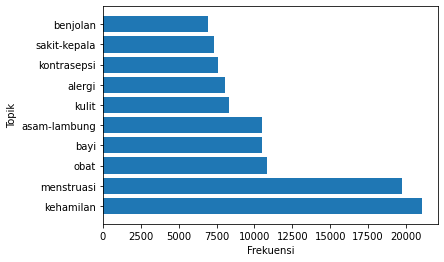

In [60]:
f, ax = plt.subplots()

plt.barh(labels2_name, labels2_freq)
plt.xlabel("Frekuensi")
plt.ylabel("Topik")
# plt.title('Frequency of Top 10 Topics in Selected & Cleaned Dataset')

plt.show()

In [7]:
df_labels = pd.read_csv("labels.csv")
df_labels

,index,label
0,0,menstruasi
1,1,kehamilan
2,2,obat
3,3,asam-lambung
4,4,bayi
5,5,sakit-kepala
6,6,benjolan
7,7,kulit
8,8,alergi
9,9,kontrasepsi


In [9]:
one_hot_labels = pd.DataFrame(df.labelmap.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
formatted_data = pd.concat([df, one_hot_labels], axis=1)

In [8]:
labels = df_labels['label'].values
labels

array(['menstruasi', 'kehamilan', 'obat', 'asam-lambung', 'bayi',
       'sakit-kepala', 'benjolan', 'kulit', 'alergi', 'kontrasepsi'],
      dtype=object)

In [10]:
import pickle 
print(pickle.format_version)

4.0


# Pretrained Embeddings

## FastText

In [11]:
embedding_path = "cc.id.300.bin/cc.id.300.bin"
ft = fasttext.load_facebook_model(embedding_path)
# ft.wv.save('fasttext_gensim.model')

## Word2Vec

In [12]:
id_w2v = KeyedVectors.load("id-word2vec", mmap='r')
len(id_w2v)

331792

# Train and Test Dataframe

## Declare

In [27]:
# Tokenize 'text_clean' column
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(formatted_data['text_clean_fixtypo'])

with open('tokenizer_text_fixtypo.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# max_length = max([len(seq) for seq in sequences])
max_length = 300

Found 41091 unique tokens.


In [15]:
train_df = pd.read_pickle("alodokter_train_text.pkl")
train_df = train_df.reset_index()
train_df = train_df.iloc[:, 1:]
train_df['label'] = train_df['label'].apply(lambda x: np.array(x))

test_df = pd.read_pickle("alodokter_test_text.pkl")
test_df = test_df.reset_index()
test_df = test_df.iloc[:, 1:]
test_df['label'] = test_df['label'].apply(lambda x: np.array(x))

In [18]:
train_df['text_clean'] = train_df['text_clean'].apply(lambda xs: ''.join(str(x) for x in xs))
test_df['text_clean'] = test_df['text_clean'].apply(lambda xs: ''.join(str(x) for x in xs))

In [21]:
train_one_hot = pd.DataFrame(train_df.label.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
test_one_hot = pd.DataFrame(test_df.label.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])

In [22]:
train_df = pd.concat([train_df, train_one_hot], axis=1)
test_df = pd.concat([test_df, test_one_hot], axis=1)

In [23]:
X_train = train_df[['text_clean']].values
X_test = test_df[['text_clean']].values

y_train = train_df[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values
y_test = test_df[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values

### Format declared

In [28]:
# Vectorize text
train_sequences = tokenizer.texts_to_sequences(np.concatenate(X_train))
test_sequences = tokenizer.texts_to_sequences(np.concatenate(X_test))

# Create padded sequences for vectorized text
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [29]:
X_train = train_padded_sequences
X_test = test_padded_sequences

## Load

In [37]:
train_df = pd.read_pickle("alodokter_train.pkl")
train_df = train_df.reset_index()
train_df = train_df.iloc[:, 1:]
train_df['label'] = train_df['label'].apply(lambda x: np.array(x))
train_df

,text_clean,label
0,hitung hari beri dosis zinc bayi diare bagaima...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,dosis obat aktif ipratropium bromide salbutamo...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,dampak cincin bahan dasar timah hadap sehat tu...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,dosis cara obat nebulasi mohon saran berapa do...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,efek samping campur body lotion tanya baik mem...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
...,...,...
66192,bahaya salah dosis obat antivirus tanya bahaya...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
66193,bolehkah obat acyclovir konsumsi seblum makan ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
66194,torch program hamil salam sept lalu gugur hami...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
66195,beri obat anak sakit gigi gusi bengkak abses g...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [38]:
test_df = pd.read_pickle("alodokter_test.pkl")
test_df = test_df.reset_index()
test_df = test_df.iloc[:, 1:]
test_df['label'] = test_df['label'].apply(lambda x: np.array(x))
test_df

,text_clean,label
0,konsumsi zinc derita asam lambung punya riwaya...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,lidah mati rasa kumur sabun cair slmt salah ku...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,beda obat tradisional obat kimia tanya bagaima...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,aman kalung buat batu germanium klinis kena ka...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,dampak konsumsi jenis obat cara sama cara halu...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
28375,pasca pasang ring jantung pasang ring jantung ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
28376,sakit dada belah kiri atas sakit dada belah ki...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
28377,nyeri rusuk dekat jantung sore tanya nyeri car...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
28378,sakit dada gerak rasa sakit dada gerak dada te...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


### Format loaded train & test data

In [43]:
train_one_hot_labels = pd.DataFrame(train_df.label.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
test_one_hot_labels = pd.DataFrame(test_df.label.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])

In [44]:
train_df = pd.concat([train_df, train_one_hot_labels], axis=1)
test_df = pd.concat([test_df, test_one_hot_labels], axis=1)

In [45]:
## Split X and y
# from skmultilearn.model_selection import iterative_train_test_split
# X_train, y_train, X_test, y_test = iterative_train_test_split(formatted_data[['text_clean']].values, formatted_data[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values, test_size=0.3)

X_train = train_df[['text_clean']].values
y_train = train_df[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values
X_test = test_df[['text_clean']].values
y_test = test_df[['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi']].values

# TF-IDF

In [32]:
tfidf_vect = TfidfVectorizer(max_features=300, analyzer='word')
tfidf_vect.fit(formatted_data['text_clean_fixtypo'])

TfidfVectorizer(max_features=300)

In [37]:
X_train_tfidf = tfidf_vect.transform(np.concatenate(X_train))
X_test_tfidf = tfidf_vect.transform(np.concatenate(X_test))

In [58]:
X_train_tfidf[0][0]

<1x300 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

# Similarity

## BERT
https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1

In [15]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

In [18]:
sentences = [
    "Apakah penggunaan pengharum ruangan aman saat sedang hamil?",
    "Hallo dok, saya sedang hamil pertama 5 minggu. apakah spray pengharum ruangan berbahaya untuk ibu hamil? bagaimana dengan yg berbentuk padat?",
    "Pada ibu hamil,  menghirup zat kimia pada pengharum ruangan umumnya tidak akan berdampak buruk bagi janin jika zat kimia yang dikandung pada pengharum tidak termasuk kategori zat kimia yang berbahaya."
]

tokens = {'input_ids': [], 'attention_mask': []}

In [19]:
for sentence in sentences:
    new_tokens = tokenizer.encode_plus(sentence, max_length=300, truncation=True, padding='max_length', return_tensors='pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

In [20]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [21]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 1.0949,  1.7669,  0.4267,  ..., -0.0986, -0.4097, -0.4406],
         [ 1.2401, -0.1196, -0.5885,  ..., -0.8969, -1.3507,  0.9605],
         [ 1.2548,  0.0757, -0.3044,  ...,  0.5177,  0.2041,  0.7379],
         ...,
         [ 0.9186,  0.0944,  0.7207,  ...,  1.6161, -0.7001,  0.5215],
         [ 0.7083,  0.7066,  1.0241,  ...,  1.8716, -0.8626,  0.5686],
         [ 0.8171,  0.9980,  0.4813,  ...,  1.8599, -0.6993,  0.4396]],

        [[ 1.6307,  2.4593,  0.4220,  ..., -0.4518, -0.5253,  0.7145],
         [ 1.3774,  0.3732,  0.3189,  ...,  0.2296, -1.7003,  1.4176],
         [ 0.5916,  1.4308,  0.1908,  ..., -1.7347, -1.0567,  0.8568],
         ...,
         [ 1.2565,  1.9991, -1.0787,  ...,  0.3172,  0.3515,  0.7427],
         [ 2.0784,  2.3264,  0.9163,  ...,  1.0030, -0.2987,  0.7510],
         [ 2.3860,  2.3045,  0.9439,  ...,  0.9180, -0.4992,  0.6267]],

        [[ 0.6255,  2.3116,  0.5537,  ..., -0.4201,  

In [22]:
embeddings = outputs.last_hidden_state
embeddings

tensor([[[ 1.0949,  1.7669,  0.4267,  ..., -0.0986, -0.4097, -0.4406],
         [ 1.2401, -0.1196, -0.5885,  ..., -0.8969, -1.3507,  0.9605],
         [ 1.2548,  0.0757, -0.3044,  ...,  0.5177,  0.2041,  0.7379],
         ...,
         [ 0.9186,  0.0944,  0.7207,  ...,  1.6161, -0.7001,  0.5215],
         [ 0.7083,  0.7066,  1.0241,  ...,  1.8716, -0.8626,  0.5686],
         [ 0.8171,  0.9980,  0.4813,  ...,  1.8599, -0.6993,  0.4396]],

        [[ 1.6307,  2.4593,  0.4220,  ..., -0.4518, -0.5253,  0.7145],
         [ 1.3774,  0.3732,  0.3189,  ...,  0.2296, -1.7003,  1.4176],
         [ 0.5916,  1.4308,  0.1908,  ..., -1.7347, -1.0567,  0.8568],
         ...,
         [ 1.2565,  1.9991, -1.0787,  ...,  0.3172,  0.3515,  0.7427],
         [ 2.0784,  2.3264,  0.9163,  ...,  1.0030, -0.2987,  0.7510],
         [ 2.3860,  2.3045,  0.9439,  ...,  0.9180, -0.4992,  0.6267]],

        [[ 0.6255,  2.3116,  0.5537,  ..., -0.4201,  0.0029, -0.3798],
         [ 1.0287,  0.0354, -1.5324,  ...,  0

In [24]:
embeddings.shape

torch.Size([3, 300, 768])

In [26]:
attention_mask = tokens['attention_mask']
attention_mask.shape

torch.Size([3, 300])

In [27]:
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([3, 300, 768])

In [28]:
mask

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [29]:
masked_embeddings = embeddings * mask
masked_embeddings.shape

torch.Size([3, 300, 768])

In [30]:
masked_embeddings

tensor([[[ 1.0949,  1.7669,  0.4267,  ..., -0.0986, -0.4097, -0.4406],
         [ 1.2401, -0.1196, -0.5885,  ..., -0.8969, -1.3507,  0.9605],
         [ 1.2548,  0.0757, -0.3044,  ...,  0.5177,  0.2041,  0.7379],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],

        [[ 1.6307,  2.4593,  0.4220,  ..., -0.4518, -0.5253,  0.7145],
         [ 1.3774,  0.3732,  0.3189,  ...,  0.2296, -1.7003,  1.4176],
         [ 0.5916,  1.4308,  0.1908,  ..., -1.7347, -1.0567,  0.8568],
         ...,
         [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],

        [[ 0.6255,  2.3116,  0.5537,  ..., -0.4201,  0.0029, -0.3798],
         [ 1.0287,  0.0354, -1.5324,  ...,  0

In [31]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([3, 768])

In [32]:
summed_mask = torch.clamp(mask.sum(1), min=1e-9)
summed_mask.shape

torch.Size([3, 768])

In [33]:
mean_pooled = summed/summed_mask
mean_pooled

tensor([[ 0.3762,  0.6097, -0.4639,  ...,  0.6115, -0.1983,  0.2468],
        [ 0.8959,  0.8238,  0.1419,  ...,  0.0320, -0.7549,  0.7890],
        [-0.0134,  0.5441, -0.3975,  ...,  0.7102, -0.5355, -0.2773]],
       grad_fn=<DivBackward0>)

In [34]:
mean_pooled = mean_pooled.detach().numpy()

cosine_similarity(
    [mean_pooled[0]],
    mean_pooled[1:]
)

array([[0.7314513 , 0.63201934]], dtype=float32)

## TFIDF

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Tugas
[nltk_data]     Akhir\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [43]:
indo = stopwords.words('indonesian')
tfidf_vectorizer = TfidfVectorizer(stop_words=indo)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_clean'])

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [ ]:
cos = 

# ML Classification

## Multinomial Naive Bayes

In [30]:
NB_model = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [38]:
NB_model.fit(X_train_tfidf, y_train)
# compute the testing accuracy
NB_predictions = NB_model.predict(X_test_tfidf)
pred_proba = NB_model.predict_proba(X_test_tfidf)
print("confusion matrix: ", multilabel_confusion_matrix(y_test, NB_predictions))

confusion matrix:  [[[23556  1336]
  [ 1326  4469]]

 [[23516   882]
  [ 2418  3871]]

 [[27356   144]
  [ 2192   995]]

 [[27361   216]
  [ 1036  2074]]

 [[27419   102]
  [ 1206  1960]]

 [[28420    84]
  [  963  1220]]

 [[28500    93]
  [  699  1395]]

 [[27272   817]
  [ 1363  1235]]

 [[27644   542]
  [ 1487  1014]]

 [[28298   126]
  [ 1547   716]]]


In [40]:
print(classification_report(y_test, NB_predictions, target_names=labels))

              precision    recall  f1-score   support

  menstruasi       0.77      0.77      0.77      5795
   kehamilan       0.81      0.62      0.70      6289
        obat       0.87      0.31      0.46      3187
asam-lambung       0.91      0.67      0.77      3110
        bayi       0.95      0.62      0.75      3166
sakit-kepala       0.94      0.56      0.70      2183
    benjolan       0.94      0.67      0.78      2094
       kulit       0.60      0.48      0.53      2598
      alergi       0.65      0.41      0.50      2501
 kontrasepsi       0.85      0.32      0.46      2263

   micro avg       0.81      0.57      0.67     33186
   macro avg       0.83      0.54      0.64     33186
weighted avg       0.82      0.57      0.66     33186
 samples avg       0.56      0.58      0.56     33186



C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
print("Subset Accuracy: " + str(accuracy_score(y_test, NB_predictions)))
print("Hamming Loss: " + str(hamming_loss(y_test, NB_predictions)))

Subset Accuracy: 0.4816697624401212
Hamming Loss: 0.06054355264444227


## Gaussian Naive Bayes

In [42]:
from skmultilearn.problem_transform import BinaryRelevance
GaussianNB_model = BinaryRelevance(GaussianNB())
GaussianNB_model.fit(X_train_tfidf, y_train)
GaussianNB_predictions = GaussianNB_model.predict(X_test_tfidf)
print("confusion matrix: ", multilabel_confusion_matrix(y_test, GaussianNB_predictions))

confusion matrix:  [[[19709  5183]
  [  488  5307]]

 [[18123  6275]
  [  803  5486]]

 [[21550  5950]
  [  574  2613]]

 [[23160  4417]
  [  198  2912]]

 [[21918  5603]
  [  169  2997]]

 [[23337  5167]
  [  181  2002]]

 [[23483  5110]
  [  137  1957]]

 [[21608  6481]
  [  198  2400]]

 [[20814  7372]
  [  243  2258]]

 [[20343  8081]
  [  208  2055]]]


In [44]:
print(classification_report(y_test, GaussianNB_predictions, target_names=labels))

              precision    recall  f1-score   support

  menstruasi       0.51      0.92      0.65      5795
   kehamilan       0.47      0.87      0.61      6289
        obat       0.31      0.82      0.44      3187
asam-lambung       0.40      0.94      0.56      3110
        bayi       0.35      0.95      0.51      3166
sakit-kepala       0.28      0.92      0.43      2183
    benjolan       0.28      0.93      0.43      2094
       kulit       0.27      0.92      0.42      2598
      alergi       0.23      0.90      0.37      2501
 kontrasepsi       0.20      0.91      0.33      2263

   micro avg       0.33      0.90      0.49     33186
   macro avg       0.33      0.91      0.47     33186
weighted avg       0.37      0.90      0.51     33186
 samples avg       0.39      0.91      0.52     33186



C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print("Subset Accuracy: " + str(accuracy_score(y_test, GaussianNB_predictions)))
print("Hamming Loss: " + str(hamming_loss(y_test, GaussianNB_predictions)))

Subset Accuracy: 0.09264509401375175
Hamming Loss: 0.20477074982891777


## SVM

In [46]:
SVM_model = OneVsRestClassifier(LinearSVC(), n_jobs=1)
SVM_model.fit(X_train_tfidf, y_train)
# compute the testing accuracy
SVM_predictions = SVM_model.predict(X_test_tfidf)
print("confusion matrix: ", multilabel_confusion_matrix(y_test, SVM_predictions))

confusion matrix:  [[[24098   794]
  [  759  5036]]

 [[23665   733]
  [  994  5295]]

 [[27007   493]
  [ 1082  2105]]

 [[27233   344]
  [  490  2620]]

 [[27304   217]
  [  245  2921]]

 [[28324   180]
  [  291  1892]]

 [[28441   152]
  [  279  1815]]

 [[27517   572]
  [ 1198  1400]]

 [[27711   475]
  [ 1212  1289]]

 [[28119   305]
  [  984  1279]]]


In [47]:
print(classification_report(y_test, SVM_predictions, target_names=labels))

              precision    recall  f1-score   support

  menstruasi       0.86      0.87      0.87      5795
   kehamilan       0.88      0.84      0.86      6289
        obat       0.81      0.66      0.73      3187
asam-lambung       0.88      0.84      0.86      3110
        bayi       0.93      0.92      0.93      3166
sakit-kepala       0.91      0.87      0.89      2183
    benjolan       0.92      0.87      0.89      2094
       kulit       0.71      0.54      0.61      2598
      alergi       0.73      0.52      0.60      2501
 kontrasepsi       0.81      0.57      0.66      2263

   micro avg       0.86      0.77      0.81     33186
   macro avg       0.85      0.75      0.79     33186
weighted avg       0.85      0.77      0.81     33186
 samples avg       0.79      0.79      0.78     33186



C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print("Subset Accuracy: " + str(accuracy_score(y_test, SVM_predictions)))
print("Hamming Loss: " + str(hamming_loss(y_test, SVM_predictions)))

Subset Accuracy: 0.7077589858897905
Hamming Loss: 0.03844950630560172


## Logistic Regression

In [49]:
LR_model = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
LR_model.fit(X_train_tfidf, y_train)
LR_predictions = LR_model.predict(X_test_tfidf)
print("confusion matrix: ", multilabel_confusion_matrix(y_test, LR_predictions))

confusion matrix:  [[[24112   780]
  [  818  4977]]

 [[23663   735]
  [ 1007  5282]]

 [[27016   484]
  [ 1093  2094]]

 [[27255   322]
  [  531  2579]]

 [[27303   218]
  [  273  2893]]

 [[28327   177]
  [  312  1871]]

 [[28455   138]
  [  290  1804]]

 [[27479   610]
  [ 1209  1389]]

 [[27699   487]
  [ 1178  1323]]

 [[28116   308]
  [  976  1287]]]


In [50]:
print(classification_report(y_test, LR_predictions, target_names=labels))

              precision    recall  f1-score   support

  menstruasi       0.86      0.86      0.86      5795
   kehamilan       0.88      0.84      0.86      6289
        obat       0.81      0.66      0.73      3187
asam-lambung       0.89      0.83      0.86      3110
        bayi       0.93      0.91      0.92      3166
sakit-kepala       0.91      0.86      0.88      2183
    benjolan       0.93      0.86      0.89      2094
       kulit       0.69      0.53      0.60      2598
      alergi       0.73      0.53      0.61      2501
 kontrasepsi       0.81      0.57      0.67      2263

   micro avg       0.86      0.77      0.81     33186
   macro avg       0.84      0.74      0.79     33186
weighted avg       0.85      0.77      0.80     33186
 samples avg       0.78      0.79      0.77     33186



C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print("Subset Accuracy: " + str(accuracy_score(y_test, LR_predictions)))
print("Hamming Loss: " + str(hamming_loss(y_test, LR_predictions)))

Subset Accuracy: 0.7011112197347411
Hamming Loss: 0.03892853651383322


## MLkNN

In [52]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'

clf = GridSearchCV(MLkNN(), parameters, scoring=score)
clf.fit(X_train_tfidf, y_train)

print(clf.best_params_, clf.best_score_)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\skmultilearn\adapt\mlknn.py", line 218, in fit
    self._cond_prob_true, self._cond_prob_false = self._compute_cond(X, self._label_cache)
  File "C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\skmultilearn\adapt\mlknn.py", line 165, in _compute_cond
    self.knn_ = NearestNeighbors(self.k).fit(X)
TypeError: __init__() takes 1 positional argument but 2 were given


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnClf = KNeighborsClassifier()
knnClf.fit(X_train_tfidf, y_train)
knn_predictions = knnClf.predict(X_test_tfidf)
print("confusion matrix: ", multilabel_confusion_matrix(y_test, knn_predictions))

In [ ]:
print(classification_report(y_test, knn_predictions, target_names=labels))

In [ ]:
print("Subset Accuracy: " + str(accuracy_score(y_test, knn_predictions)))
print("Hamming Loss: " + str(hamming_loss(y_test, knn_predictions)))

## Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(X_train_tfidf, y_train)
dt_predictions = dtClassifier.predict(X_test_tfidf)
print("confusion matrix: ", multilabel_confusion_matrix(y_test, dt_predictions))

confusion matrix:  [[[23763  1129]
  [ 1044  4751]]

 [[23218  1180]
  [ 1166  5123]]

 [[26411  1089]
  [ 1153  2034]]

 [[26878   699]
  [  602  2508]]

 [[27195   326]
  [  293  2873]]

 [[28178   326]
  [  362  1821]]

 [[28256   337]
  [  345  1749]]

 [[27006  1083]
  [ 1180  1418]]

 [[27024  1162]
  [ 1196  1305]]

 [[27541   883]
  [  908  1355]]]


In [54]:
print(classification_report(y_test, dt_predictions, target_names=labels))

              precision    recall  f1-score   support

  menstruasi       0.81      0.82      0.81      5795
   kehamilan       0.81      0.81      0.81      6289
        obat       0.65      0.64      0.64      3187
asam-lambung       0.78      0.81      0.79      3110
        bayi       0.90      0.91      0.90      3166
sakit-kepala       0.85      0.83      0.84      2183
    benjolan       0.84      0.84      0.84      2094
       kulit       0.57      0.55      0.56      2598
      alergi       0.53      0.52      0.53      2501
 kontrasepsi       0.61      0.60      0.60      2263

   micro avg       0.75      0.75      0.75     33186
   macro avg       0.73      0.73      0.73     33186
weighted avg       0.75      0.75      0.75     33186
 samples avg       0.77      0.77      0.76     33186



C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print("Subset Accuracy: " + str(accuracy_score(y_test, dt_predictions)))
print("Hamming Loss: " + str(hamming_loss(y_test, dt_predictions)))

Subset Accuracy: 0.6829602111643367
Hamming Loss: 0.05364812461302832


## Random Forest

# DL Classification

In [44]:
epochs1 = 10
epochs2 = 50

val_split1 = 0.1
val_split2 = 0.33

batch_size1 = 32
batch_size2 = 64

In [45]:
input_dim = len(word_index) + 1
output_dim = 300
input_dim

34897

In [46]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    
    return np.mean(acc_list)

In [61]:
embedding_matrix = np.zeros((len(word_index) + 1, ft.vector_size))
oov = 0
oov_list = []

'''
For FastText
'''
for word, i in word_index.items():
    if ft.wv[word] is not None:
        embedding_matrix[i] = ft.wv[word]
    else:
        oov += 1

print("Out of vocab: ")
print(oov)

Out of vocab: 
0


## BiLSTM-CNN

In [72]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
gru2 = Bidirectional(LSTM(64))(embedding2)
drop2 = Dropout(0.5)(gru2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
BiLSTMCNN = Model(inputs=[input1, input2], outputs=outputs)

BiLSTMCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiLSTMCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     10469100    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

In [73]:
mc = ModelCheckpoint('BestModels/bilstmcnn_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

BiLSTMCNN_fit = BiLSTMCNN.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
BiLSTMCNN.save('BiLSTMCNN_fixtypo')

Epoch 1/50
933/933 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.3770
Epoch 1: val_accuracy improved from -inf to 0.08644, saving model to BestModels\bilstmcnn_fixtypo.h5
933/933 [==============================] - 306s 325ms/step - loss: 0.3109 - accuracy: 0.3770 - val_loss: 0.3098 - val_accuracy: 0.0864
Epoch 2/50
933/933 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.7560
Epoch 2: val_accuracy improved from 0.08644 to 0.57746, saving model to BestModels\bilstmcnn_fixtypo.h5
933/933 [==============================] - 317s 339ms/step - loss: 0.1689 - accuracy: 0.7560 - val_loss: 0.1896 - val_accuracy: 0.5775
Epoch 3/50
933/933 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.7915
Epoch 3: val_accuracy improved from 0.57746 to 0.71444, saving model to BestModels\bilstmcnn_fixtypo.h5
933/933 [==============================] - 334s 358ms/step - loss: 0.1227 - accuracy: 0.7915 - val_loss: 0.1725 - val_accuracy: 0.714

INFO:tensorflow:Assets written to: BiLSTMCNN_fixtypo\assets


INFO:tensorflow:Assets written to: BiLSTMCNN_fixtypo\assets


In [74]:
BiLSTMCNN_best = load_model('BestModels/bilstmcnn_fixtypo.h5')
BiLSTMCNN_train_score = BiLSTMCNN_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiLSTMCNN_train_score[0])
print('Train Accuracy:', BiLSTMCNN_train_score[1])

BiLSTMCNN_test_score = BiLSTMCNN_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiLSTMCNN_test_score[0])
print('Test Accuracy:', BiLSTMCNN_test_score[1])

1036/1036 [==============================] - 576s 555ms/step - loss: 0.0433 - accuracy: 0.8790
Train Loss: 0.04333309829235077
Train Accuracy: 0.879044771194458
444/444 [==============================] - 269s 605ms/step - loss: 0.0844 - accuracy: 0.8236
Test Loss: 0.08439330756664276
Test Accuracy: 0.823618471622467


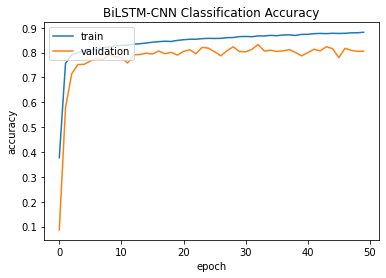

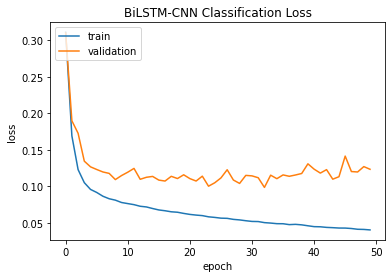

In [75]:
BiLSTMCNN_history_dict = BiLSTMCNN_fit.history
plt.plot(BiLSTMCNN_history_dict['accuracy'])
plt.plot(BiLSTMCNN_history_dict['val_accuracy'])

plt.title('BiLSTM-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiLSTMCNN_history_dict['loss'])
plt.plot(BiLSTMCNN_history_dict['val_loss'])

plt.title('BiLSTM-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [76]:
BiLSTMCNN_y_pred = BiLSTMCNN_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)
# lebih dari 0.5 dihitung sebagai 1
BiLSTMCNN_predictions = (BiLSTMCNN_y_pred > 0.5).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiLSTMCNN_predictions))

444/444 [==============================] - 229s 514ms/step
0.7839493136219641


In [79]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiLSTMCNN_predictions)
hamming_loss.result().numpy()

0.029176341

In [81]:
report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiLSTMCNN_predictions, target_names=categories, output_dict=True)
).transpose()

report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.882782,0.925634,0.903700,4182.0
kehamilan,0.869743,0.851344,0.860445,3498.0
obat,0.836270,0.804265,0.819955,3423.0
asam-lambung,0.910317,0.864830,0.886991,3122.0
bayi,0.940954,0.967532,0.954058,3080.0
sakit-kepala,0.928525,0.950247,0.939261,3035.0
benjolan,0.935107,0.953358,0.944144,3023.0
kulit,0.775844,0.733706,0.754187,3038.0
alergi,0.771366,0.694508,0.730922,3041.0
kontrasepsi,0.933192,0.867565,0.899183,3043.0


In [77]:
BiLSTMCNN_cf_matrix = multilabel_confusion_matrix(y_test, BiLSTMCNN_predictions)
# TN  TP
# FN  FP
BiLSTMCNN_cf_matrix

array([[[23714,   514],
        [  311,  3871]],

       [[24466,   446],
        [  520,  2978]],

       [[24448,   539],
        [  670,  2753]],

       [[25022,   266],
        [  422,  2700]],

       [[25143,   187],
        [  100,  2980]],

       [[25153,   222],
        [  151,  2884]],

       [[25187,   200],
        [  141,  2882]],

       [[24728,   644],
        [  809,  2229]],

       [[24743,   626],
        [  929,  2112]],

       [[25178,   189],
        [  403,  2640]]], dtype=int64)

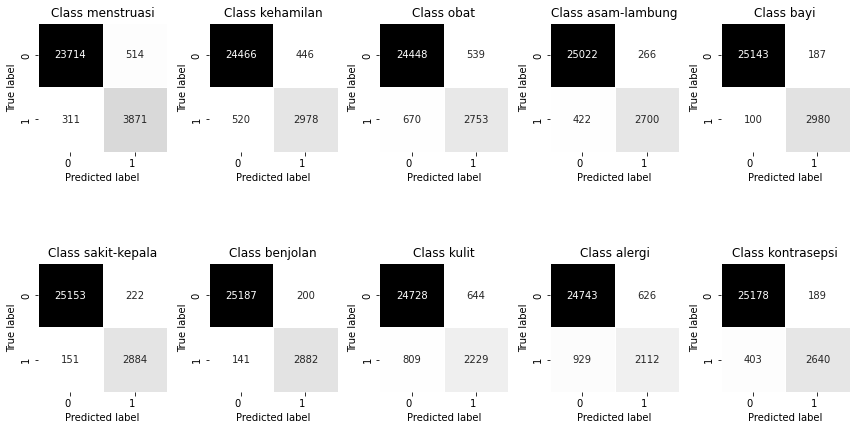

<Figure size 432x288 with 0 Axes>

In [80]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiLSTMCNN_cf_matrix, categories):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiLSTMCNN_fixtypo.png', bbox_inches="tight")

## BiGRU-CNN

In [85]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
gru2 = Bidirectional(GRU(64))(embedding2)
drop2 = Dropout(0.5)(gru2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
BiGRUCNN = Model(inputs=[input1, input2], outputs=outputs)

BiGRUCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
BiGRUCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     10469100    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

In [87]:
mc = ModelCheckpoint('BestModels/bigrucnn_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

BiGRUCNN_fit = BiGRUCNN.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
BiGRUCNN.save('BiGRUCNN_fixtypo')

Epoch 1/50
933/933 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.4187
Epoch 1: val_accuracy improved from -inf to 0.11631, saving model to BestModels\bigrucnn_fixtypo.h5
933/933 [==============================] - 338s 363ms/step - loss: 0.3068 - accuracy: 0.4187 - val_loss: 0.2913 - val_accuracy: 0.1163
Epoch 2/50
933/933 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.7483
Epoch 2: val_accuracy improved from 0.11631 to 0.61110, saving model to BestModels\bigrucnn_fixtypo.h5
933/933 [==============================] - 341s 365ms/step - loss: 0.1746 - accuracy: 0.7483 - val_loss: 0.2063 - val_accuracy: 0.6111
Epoch 3/50
933/933 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.7970
Epoch 3: val_accuracy improved from 0.61110 to 0.72319, saving model to BestModels\bigrucnn_fixtypo.h5
933/933 [==============================] - 341s 366ms/step - loss: 0.1237 - accuracy: 0.7970 - val_loss: 0.1617 - val_accuracy: 0.7232
E

INFO:tensorflow:Assets written to: BiGRUCNN_fixtypo\assets


INFO:tensorflow:Assets written to: BiGRUCNN_fixtypo\assets


In [88]:
BiGRUCNN_best = load_model('BestModels/bigrucnn_fixtypo.h5')
BiGRUCNN_train_score = BiGRUCNN_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', BiGRUCNN_train_score[0])
print('Train Accuracy:', BiGRUCNN_train_score[1])

BiGRUCNN_test_score = BiGRUCNN_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', BiGRUCNN_test_score[0])
print('Test Accuracy:', BiGRUCNN_test_score[1])

1036/1036 [==============================] - 536s 517ms/step - loss: 0.0387 - accuracy: 0.8738
Train Loss: 0.03870989382266998
Train Accuracy: 0.8738101124763489
444/444 [==============================] - 229s 517ms/step - loss: 0.0863 - accuracy: 0.8100
Test Loss: 0.08630208671092987
Test Accuracy: 0.809996485710144


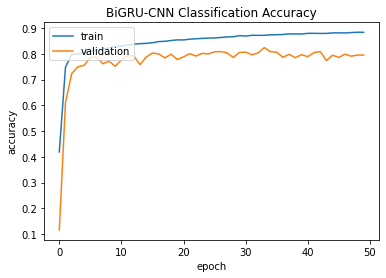

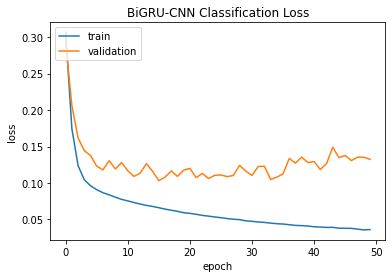

In [89]:
BiGRUCNN_history_dict = BiGRUCNN_fit.history
plt.plot(BiGRUCNN_history_dict['accuracy'])
plt.plot(BiGRUCNN_history_dict['val_accuracy'])

plt.title('BiGRU-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(BiGRUCNN_history_dict['loss'])
plt.plot(BiGRUCNN_history_dict['val_loss'])

plt.title('BiGRU-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [91]:
BiGRUCNN_y_pred = BiGRUCNN_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)
# lebih dari 0.5 dihitung sebagai 1
BiGRUCNN_predictions = (BiGRUCNN_y_pred > 0.5).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), BiGRUCNN_predictions))

444/444 [==============================] - 231s 521ms/step
0.791129883843717


In [92]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), BiGRUCNN_predictions)
hamming_loss.result().numpy()

0.028665954

In [93]:
report_df = pd.DataFrame(
    classification_report(y_test.tolist(), BiGRUCNN_predictions, target_names=categories, output_dict=True)
).transpose()

report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.906451,0.910569,0.908505,4182.0
kehamilan,0.852722,0.882218,0.867219,3498.0
obat,0.840346,0.822670,0.831414,3423.0
asam-lambung,0.919394,0.854901,0.885975,3122.0
bayi,0.934539,0.973377,0.953562,3080.0
sakit-kepala,0.920877,0.954860,0.937561,3035.0
benjolan,0.935881,0.956004,0.945835,3023.0
kulit,0.764310,0.747202,0.755659,3038.0
alergi,0.775335,0.684314,0.726987,3041.0
kontrasepsi,0.917227,0.895826,0.906401,3043.0


In [94]:
BiGRUCNN_cf_matrix = multilabel_confusion_matrix(y_test, BiGRUCNN_predictions)
# TN  TP
# FN  FP
BiGRUCNN_cf_matrix

array([[[23835,   393],
        [  374,  3808]],

       [[24379,   533],
        [  412,  3086]],

       [[24452,   535],
        [  607,  2816]],

       [[25054,   234],
        [  453,  2669]],

       [[25120,   210],
        [   82,  2998]],

       [[25126,   249],
        [  137,  2898]],

       [[25189,   198],
        [  133,  2890]],

       [[24672,   700],
        [  768,  2270]],

       [[24766,   603],
        [  960,  2081]],

       [[25121,   246],
        [  317,  2726]]], dtype=int64)

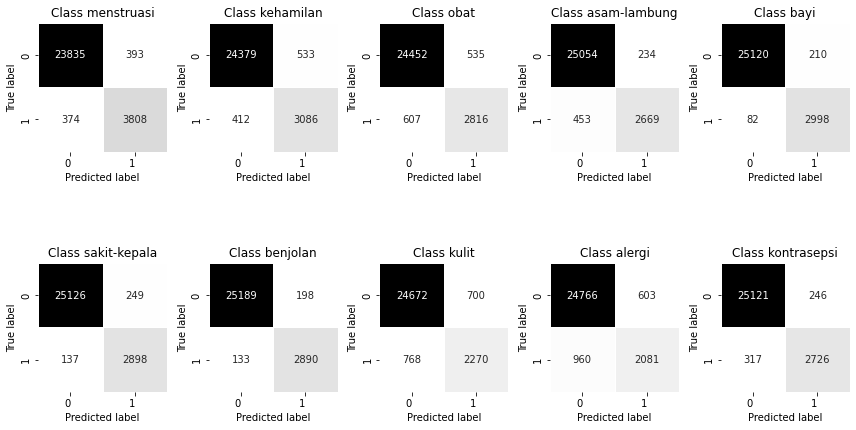

<Figure size 432x288 with 0 Axes>

In [95]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), BiGRUCNN_cf_matrix, categories):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/BiGRUCNN_fixtypo.png', bbox_inches="tight")

## LSTM-CNN

In [98]:
tf.keras.backend.clear_session()

input1 = Input(shape=(max_length,))
embedding1 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input1)
conv1 = Conv1D(100, 3, activation='relu')(embedding1)
pool1 = MaxPooling1D(2, 2)(conv1)
flat1 = Flatten()(pool1)
drop1 = Dropout(0.5)(flat1)
out1 = Dense(10, activation='sigmoid')(drop1)

input2 = Input(shape=(max_length,))
embedding2 = Embedding(input_dim, output_dim, input_length=max_length, input_shape=(max_length, ), weights=[embedding_matrix], trainable=False)(input2)
lstm2 = LSTM(64)(embedding2)
drop2 = Dropout(0.5)(lstm2)
out2 = Dense(10, activation='sigmoid')(drop2)

merged = concatenate([out1, out2])

outputs = Dense(10, activation='sigmoid')(merged)
LSTMCNN = Model(inputs=[input1, input2], outputs=outputs)

LSTMCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTMCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     10469100    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 298, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                              

In [99]:
mc = ModelCheckpoint('BestModels/lstmcnn_fixtypo.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

LSTMCNN_fit = LSTMCNN.fit([X_train, X_train], y_train, batch_size=batch_size2, epochs=epochs2, validation_split=val_split1, callbacks=[mc])
LSTMCNN.save('LSTMCNN_fixtypo')

Epoch 1/50
933/933 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.4599
Epoch 1: val_accuracy improved from -inf to 0.09594, saving model to BestModels\lstmcnn_fixtypo.h5
933/933 [==============================] - 532s 569ms/step - loss: 0.3205 - accuracy: 0.4599 - val_loss: 0.3069 - val_accuracy: 0.0959
Epoch 2/50
933/933 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.7702
Epoch 2: val_accuracy improved from 0.09594 to 0.53688, saving model to BestModels\lstmcnn_fixtypo.h5
933/933 [==============================] - 525s 563ms/step - loss: 0.1710 - accuracy: 0.7702 - val_loss: 0.2117 - val_accuracy: 0.5369
Epoch 3/50
933/933 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.7938
Epoch 3: val_accuracy improved from 0.53688 to 0.54473, saving model to BestModels\lstmcnn_fixtypo.h5
933/933 [==============================] - 523s 561ms/step - loss: 0.1314 - accuracy: 0.7938 - val_loss: 0.1858 - val_accuracy: 0.5447
Epoc

INFO:tensorflow:Assets written to: LSTMCNN_fixtypo\assets


INFO:tensorflow:Assets written to: LSTMCNN_fixtypo\assets


In [100]:
LSTMCNN_best = load_model('BestModels/lstmcnn_fixtypo.h5')
LSTMCNN_train_score = LSTMCNN_best.evaluate([X_train, X_train], y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTMCNN_train_score[0])
print('Train Accuracy:', LSTMCNN_train_score[1])

LSTMCNN_test_score = LSTMCNN_best.evaluate([X_test, X_test], y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', LSTMCNN_test_score[0])
print('Test Accuracy:', LSTMCNN_test_score[1])

1036/1036 [==============================] - 531s 512ms/step - loss: 0.0584 - accuracy: 0.8616
Train Loss: 0.058382946997880936
Train Accuracy: 0.8616361618041992
444/444 [==============================] - 226s 510ms/step - loss: 0.0869 - accuracy: 0.8169
Test Loss: 0.0868949219584465
Test Accuracy: 0.8169306516647339


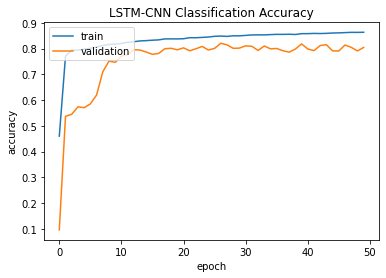

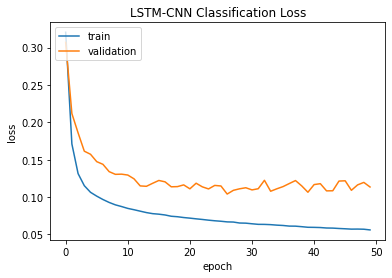

In [101]:
LSTMCNN_history_dict = LSTMCNN_fit.history
plt.plot(LSTMCNN_history_dict['accuracy'])
plt.plot(LSTMCNN_history_dict['val_accuracy'])

plt.title('LSTM-CNN Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(LSTMCNN_history_dict['loss'])
plt.plot(LSTMCNN_history_dict['val_loss'])

plt.title('LSTM-CNN Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [102]:
LSTMCNN_y_pred = LSTMCNN_best.predict([X_test, X_test], batch_size=batch_size2, verbose=1)
# lebih dari 0.5 dihitung sebagai 1
LSTMCNN_predictions = (LSTMCNN_y_pred > 0.5).astype(int)

# Subset accuracy: % of samples that have ALL the labels classified correctly
print(accuracy_score(y_test.tolist(), LSTMCNN_predictions))

444/444 [==============================] - 225s 507ms/step
0.7667722632875748


In [103]:
hamming_loss = HammingLoss(mode='multilabel')
hamming_loss.update_state(y_test.tolist(), LSTMCNN_predictions)
hamming_loss.result().numpy()

0.031136915

In [104]:
report_df = pd.DataFrame(
    classification_report(y_test.tolist(), LSTMCNN_predictions, target_names=categories, output_dict=True)
).transpose()

report_df

C:\Users\Tugas Akhir\anaconda3\envs\MLenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
menstruasi,0.884848,0.907700,0.896128,4182.0
kehamilan,0.853387,0.853631,0.853509,3498.0
obat,0.838387,0.783523,0.810027,3423.0
asam-lambung,0.920820,0.834401,0.875483,3122.0
bayi,0.944603,0.968831,0.956564,3080.0
sakit-kepala,0.918188,0.928171,0.923153,3035.0
benjolan,0.943309,0.946742,0.945022,3023.0
kulit,0.749333,0.739961,0.744617,3038.0
alergi,0.788043,0.619862,0.693908,3041.0
kontrasepsi,0.903631,0.875123,0.889149,3043.0


In [105]:
LSTMCNN_cf_matrix = multilabel_confusion_matrix(y_test, LSTMCNN_predictions)
# TN  TP
# FN  FP
LSTMCNN_cf_matrix

array([[[23734,   494],
        [  386,  3796]],

       [[24399,   513],
        [  512,  2986]],

       [[24470,   517],
        [  741,  2682]],

       [[25064,   224],
        [  517,  2605]],

       [[25155,   175],
        [   96,  2984]],

       [[25124,   251],
        [  218,  2817]],

       [[25215,   172],
        [  161,  2862]],

       [[24620,   752],
        [  790,  2248]],

       [[24862,   507],
        [ 1156,  1885]],

       [[25083,   284],
        [  380,  2663]]], dtype=int64)

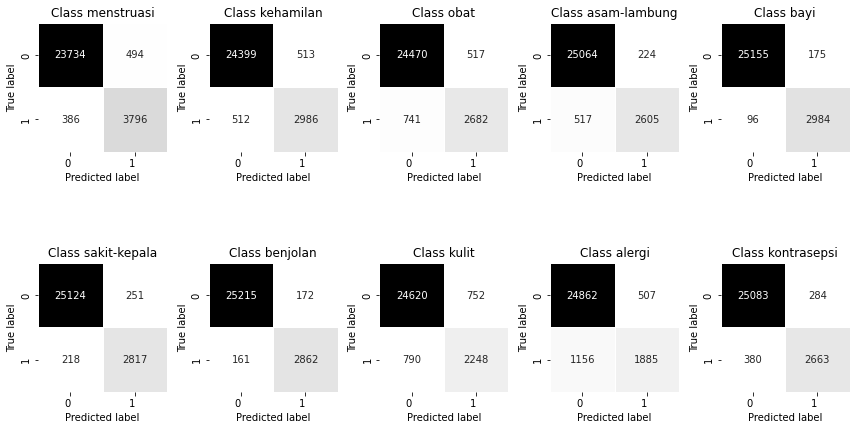

<Figure size 432x288 with 0 Axes>

In [106]:
f, axes = plt.subplots(2, 5, figsize=(12,7))

for ax, cfm, label in zip(axes.flatten(), LSTMCNN_cf_matrix, categories):
    cf_df = pd.DataFrame(cfm, index=["0", "1"], columns=["0", "1"])
    heatmap = sns.heatmap(cf_df, annot=True, fmt="d", cbar=False, ax=ax, cmap='binary', square=True, linewidths=0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Class {label}')

f.tight_layout()
plt.show()
plt.savefig('ConfusionMatrix/LSTMCNN_fixtypo.png', bbox_inches="tight")